# **0. Dataset Preparation**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, learning_curve 

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint # type: ignore
from tensorflow.keras import layers, Model , regularizers # type: ignore

from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"
os.environ["TF_NUM_INTEROP_THREADS"] = "1"
random.seed(42); np.random.seed(42)

tf.random.set_seed(42)

In [ ]:
df = pd.read_csv('data/data_bersih.csv')
text_col = 'tweet_pp'
target_col = 'sentimen'

cand_num = ["n_words","n_exclaim","n_question"]
num_cols = [c for c in cand_num if c in df.columns]

In [4]:
# 1) Encode label
le = LabelEncoder()
y  = le.fit_transform(df[target_col].astype(str))

# 2) Siapkan X teks & numerik
X_text = df[text_col].astype(str).values
X_num  = df[num_cols].copy() if num_cols else pd.DataFrame(index=df.index)

# 3) Buat indeks split (dipakai ulang agar sinkron dengan auxiliary sarkasme)
idx_all = np.arange(len(df))

# 15% test, 15% val (dari sisa) -> kira-kira 70/15/15
idx_tr_all, idx_te = train_test_split(
    idx_all, test_size=0.15, random_state=42, stratify=y
)
idx_tr, idx_val = train_test_split(
    idx_tr_all, test_size=0.1765, random_state=42, stratify=y[idx_tr_all]
)

# 4) Terapkan indeks ke X dan y
X_tr_text, X_val_text, X_te_text = X_text[idx_tr], X_text[idx_val], X_text[idx_te]
X_tr_num,  X_val_num,  X_te_num  = X_num.loc[idx_tr], X_num.loc[idx_val], X_num.loc[idx_te]
y_tr, y_val, y_te = y[idx_tr], y[idx_val], y[idx_te]

print("y classes:", list(le.classes_))
print("Split sizes -> train:", len(y_tr), " val:", len(y_val), " test:", len(y_te))

y classes: ['negatif', 'netral', 'positif']
Split sizes -> train: 1269  val: 273  test: 273


In [50]:
y_sarc_full = df["sarcasm_weak"].astype("float32").values
w_sarc_full = df["sarcasm_conf"].astype("float32").values
# NaN -> 0 (tidak berkontribusi ke loss melalui bobot 0)
y_sarc_full = np.where(np.isnan(y_sarc_full), 0.0, y_sarc_full).astype("float32")
w_sarc_full = np.nan_to_num(w_sarc_full, nan=0.0).clip(0.0, 1.0).astype("float32")

y_sarc_full = np.zeros(len(df), dtype="float32")
w_sarc_full = np.zeros(len(df), dtype="float32")    

y_sarc_tr,  y_sarc_val,  y_sarc_te  = y_sarc_full[idx_tr],  y_sarc_full[idx_val],  y_sarc_full[idx_te]
w_sarc_tr,  w_sarc_val,  w_sarc_te  = w_sarc_full[idx_tr],  w_sarc_full[idx_val],  w_sarc_full[idx_te]

print("Aux present:", has_sarc,
      "| train w>0:", int((w_sarc_tr>0).sum()),
      "| val w>0:",   int((w_sarc_val>0).sum()),
      "| test w>0:",  int((w_sarc_te>0).sum()))

Aux present: True | train w>0: 0 | val w>0: 0 | test w>0: 0


## Numerik Column Preparation

In [5]:
X_tr_num["n_exclaim"] = X_tr_num["n_exclaim"].clip(upper=3)
X_val_num["n_exclaim"] = X_val_num["n_exclaim"].clip(upper=3)
X_te_num["n_exclaim"]  = X_te_num["n_exclaim"].clip(upper=3)

X_tr_num["n_question"] = X_tr_num["n_question"].clip(upper=3)
X_val_num["n_question"] = X_val_num["n_question"].clip(upper=3)
X_te_num["n_question"]  = X_te_num["n_question"].clip(upper=3)

scaler_num = StandardScaler(with_mean=True, with_std=True)
Xtr_num_std = scaler_num.fit_transform(X_tr_num.fillna(0)) if num_cols else None
Xval_num_std= scaler_num.transform(X_val_num.fillna(0))     if num_cols else None
Xte_num_std = scaler_num.transform(X_te_num.fillna(0))      if num_cols else None

print("Numeric shapes ->",
      "train:", None if Xtr_num_std is None else Xtr_num_std.shape,
      "val:",   None if Xval_num_std is None else Xval_num_std.shape,
      "test:",  None if Xte_num_std is None else Xte_num_std.shape)


Numeric shapes -> train: (1269, 5) val: (273, 5) test: (273, 5)


In [6]:
Xtr_num_std

array([[ 1.15660506, -0.24552698, -0.40935044,  1.52095888,  1.70429322],
       [ 2.03701525, -0.24552698, -0.40935044, -0.65747997, -0.58675349],
       [ 1.42072812, -0.24552698, -0.40935044,  1.52095888,  1.70429322],
       ...,
       [ 1.06856405, -0.24552698, -0.40935044, -0.65747997, -0.58675349],
       [-0.0759692 , -0.24552698, -0.40935044, -0.65747997,  1.70429322],
       [-0.0759692 , -0.24552698, -0.40935044,  1.52095888,  1.70429322]])

In [7]:
X_tr_text

array(['hmm, calon presiden 02 bilang didebat keadaan ekonomi indonesia saat ini bukan salah <user> tapi salah pemimpin pemimpin terdahulu. jadi untuk penggemar 02 jangan salahkan jokowi lagi ya karena bosmu sudah bilang itu bukan salah jokowi. <url> #prabowosalahkansby prabowosalahkansby',
       'sudah manusia kurang pergaulan macam kamu tidak mengerti mobile legend jangan sok sok berbicara begitu, nanti tol langit kamu sangka jalan yol di atas langit,, akum sampah jangan berbicara tinggi yang tidak paham atinya,, biasa main di gua terus di gaji buat jadi buzzer ya mana mengerti bahasa kamu',
       'model ngeles petruk sudah ketaker ber-busa busa di depan sandi membicarakan ekonomi makro dengan congkaknya untung sandi nya sabar tidak di kick balik pantas saja menteri2nya yang pintar pintar pada mbodoni , lah juragannya kayak begini pek*k nya .. #uasdifitnahkejibalasditps <user> <user>',
       ...,
       'rakyat ingin pekerjaan, pekerjanya diimpor dari cina. rakyat panen padi, bera

# **1. Tokenization and Padding**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

## Sequence Model

In [9]:
max_words = 12000
max_len   = 48

# Fit tokenizer di teks train
tok = Tokenizer(num_words=max_words, oov_token="<OOV>")
tok.fit_on_texts(X_tr_text)

def to_pad(x):
    return pad_sequences(tok.texts_to_sequences(x), maxlen=max_len, padding="post", truncating="post")

Xtr_pad  = to_pad(X_tr_text)
Xval_pad = to_pad(X_val_text)
Xte_pad  = to_pad(X_te_text)

vocab_size = min(max_words, len(tok.word_index) + 1)

print("Vocab size:", vocab_size, "| seq shapes ->",
      "train:", Xtr_pad.shape, "val:", Xval_pad.shape, "test:", Xte_pad.shape)

Vocab size: 5114 | seq shapes -> train: (1269, 48) val: (273, 48) test: (273, 48)


## TF-IDF untuk LogRegression, SVM, MLP

In [10]:
# DataFrame minimal untuk ColumnTransformer
df_tr  = pd.DataFrame({text_col: X_tr_text})
df_val = pd.DataFrame({text_col: X_val_text})
df_te  = pd.DataFrame({text_col: X_te_text})
for c in num_cols:
    df_tr[c], df_val[c], df_te[c] = X_tr_num[c].values, X_val_num[c].values, X_te_num[c].values

tfidf_word = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)

ct_sparse = ColumnTransformer(
    transformers=[
        ("tf",  tfidf_word, text_col),
        ("num", "passthrough", num_cols)
    ],
    remainder="drop",
    sparse_threshold=1.0
)

pipe_tfidf_svd = Pipeline([
    ("ct",  ct_sparse),
    ("svd", TruncatedSVD(n_components=300, random_state=42))
])

Xtr_tfidf  = ct_sparse.fit_transform(df_tr)
Xval_tfidf = ct_sparse.transform(df_val)
Xte_tfidf  = ct_sparse.transform(df_te)

Xtr_svd  = pipe_tfidf_svd.fit_transform(df_tr)
Xval_svd = pipe_tfidf_svd.transform(df_val)
Xte_svd  = pipe_tfidf_svd.transform(df_te)

print("TF-IDF sparse ->", Xtr_tfidf.shape, Xval_tfidf.shape, Xte_tfidf.shape)
print("TF-IDF→SVD    ->", Xtr_svd.shape,   Xval_svd.shape,   Xte_svd.shape)

TF-IDF sparse -> (1269, 5340) (273, 5340) (273, 5340)
TF-IDF→SVD    -> (1269, 300) (273, 300) (273, 300)


## Class Weight

In [11]:
from sklearn.utils.class_weight import compute_class_weight

classes      = np.unique(y_tr)
weights      = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
class_weight = {int(k): float(v) for k,v in zip(classes, weights)}

print("Class weight (train):", class_weight)

Class weight (train): {0: 1.0168269230769231, 1: 0.9952941176470588, 2: 0.9883177570093458}


## Embedding

In [88]:
VEC_PATH = "embeddings/cc.id.300.vec"   
assert os.path.isfile(VEC_PATH), f"Tidak ditemukan: {VEC_PATH}"
kv = KeyedVectors.load_word2vec_format(VEC_PATH, binary=False) # type: ignore
dim = kv.vector_size
print(f"[fastText.vec] dim={dim}, vocab={len(kv.key_to_index):,}")

[fastText.vec] dim=300, vocab=2,000,000


In [ ]:
# Xtr_emb, Xval_emb, Xte_emb, kv, dim = joblib.load("cache/avg_fasttext_vec.pkl")

In [89]:
def avg_vec(texts):
    X = np.zeros((len(texts), dim), dtype="float32")
    for i, t in enumerate(texts):
        toks = t.split()
        vecs = [kv[w] for w in toks if w in kv]
        if vecs: X[i] = np.mean(vecs, axis=0)
    return X

Xtr_emb  = avg_vec(X_tr_text)
Xval_emb = avg_vec(X_val_text)
Xte_emb  = avg_vec(X_te_text)

In [90]:
os.makedirs("cache", exist_ok=True)
joblib.dump((Xtr_emb, Xval_emb, Xte_emb, kv, dim), "cache/avg_fasttext_vec.pkl")

['cache/avg_fasttext_vec.pkl']

In [13]:
Xtr = np.hstack([Xtr_emb,  Xtr_num_std])
Xval= np.hstack([Xval_emb, Xval_num_std])
Xte = np.hstack([Xte_emb,  Xte_num_std])
print("Shapes:", "train", Xtr.shape, "| val", Xval.shape, "| test", Xte.shape)

Shapes: train (1269, 305) | val (273, 305) | test (273, 305)


# **2. Model CNN**

In [99]:
if 'embedding_matrix' not in globals():
    embedding_dim = dim  # dari kv.vector_size
    embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype="float32")
    for word, idx in tok.word_index.items():
        if idx >= vocab_size: 
            continue
        if word in kv:
            embedding_matrix[idx] = kv[word]
print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (5114, 300)


In [100]:
n_classes = len(le.classes_)
if n_classes == 2:
    y_tr_oh, y_val_oh, y_te_oh = y_tr, y_val, y_te
    out_units, out_activation, loss_fn = 1, "sigmoid", "binary_crossentropy"
else:
    y_tr_oh  = to_categorical(y_tr,  num_classes=n_classes)
    y_val_oh = to_categorical(y_val, num_classes=n_classes)
    y_te_oh  = to_categorical(y_te,  num_classes=n_classes)
    out_units, out_activation, loss_fn = n_classes, "softmax", "categorical_crossentropy"

print("Configured ->", loss_fn, "| out_units:", out_units, "| act:", out_activation)

# class weight tipis berbasis 'class_weight' yang SUDAH ADA
class_weight_thin = {int(k): float(0.5 + 0.5*v) for k, v in class_weight.items()}

Configured -> categorical_crossentropy | out_units: 3 | act: softmax


In [101]:
have_num = Xtr_num_std is not None and Xtr_num_std.shape[1] > 0
seq_len  = Xtr_pad.shape[1]
embedding_dim = embedding_matrix.shape[1]

# ---- Definisi model (Embedding awalnya frozen; akan di-unfreeze setelah warm-start) ----
seq_in = layers.Input(shape=(seq_len,), name="seq_in")
emb    = layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=seq_len,
    trainable=False,               # warm-start: frozen dulu 2–3 epoch
    name="embedding_glove_cnn"
)(seq_in)

cnn1   = layers.Conv1D(128, 5, activation='relu', padding="valid", name="conv1")(emb)
t_vec  = layers.GlobalMaxPool1D(name="gmp")(cnn1)  # sesuai sketsa arsitektur Anda

if have_num:
    num_in = layers.Input(shape=(Xtr_num_std.shape[1],), name="num_in")
    h_num  = layers.BatchNormalization(name="bn_num")(num_in)
    h_num  = layers.Dense(8, activation='relu', name="num_proj")(h_num)
    feat   = layers.Concatenate(name="concat_text_num")([t_vec, h_num])
    inputs = [seq_in, num_in]
else:
    feat   = t_vec
    inputs = seq_in

h      = layers.Dense(10, activation='relu', name="dense10")(feat)  # mengikuti sketsa
out    = layers.Dense(out_units, activation=out_activation, name="output")(h)

cnn_model = Model(inputs, out, name="CNN_Emb_warmstart_NUM")
cnn_model.summary()

Model: "CNN_Emb_warmstart_NUM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 48)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_glove_cnn │ (None, 48, 300)   │  1,534,200 │ seq_in[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 5)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv1D)      │ (None, 44, 128)   │    192,128 │ embedding_glove_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_num              │ (None, 5)         │         20 │ num_in[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gmp                 │ (None, 128)       │          0 │ conv1[0][0]       │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_proj (Dense)    │ (None, 8)         │         48 │ bn_num[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_text_num     │ (None, 136)       │          0 │ gmp[0][0],        │
│ (Concatenate)       │                   │            │ num_proj[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense10 (Dense)     │ (None, 10)        │      1,370 │ concat_text_num[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 3)         │         33 │ dense10[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,727,799 (6.59 MB)

 Trainable params: 193,589 (756.21 KB)

 Non-trainable params: 1,534,210 (5.85 MB)

In [102]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=loss_fn,
    metrics=["accuracy"]
)

ckpt_warm = "best_cnn_warm.h5"
cbs_warm = [
    ModelCheckpoint(ckpt_warm, monitor="val_accuracy", mode="max", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", mode="max", patience=2, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, verbose=1)
]

Xtr_in   = [Xtr_pad, Xtr_num_std]   if have_num else Xtr_pad
Xval_in  = [Xval_pad, Xval_num_std] if have_num else Xval_pad

In [110]:
history_warm = cnn_model.fit(
    Xtr_in, y_tr_oh,
    validation_data=(Xval_in, y_val_oh),
    epochs=20, batch_size=16, verbose=1,
    callbacks=cbs_warm,
    class_weight=class_weight_thin
)

Epoch 1/20


79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9343 - loss: 0.2772
Epoch 1: val_accuracy improved from 0.62271 to 0.63736, saving model to best_cnn_warm.h5



Epoch 1: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9496 - loss: 0.2537 - val_accuracy: 0.6374 - val_loss: 0.8822 - learning_rate: 2.5000e-04
Epoch 2/20
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9640 - loss: 0.2005
Epoch 2: val_accuracy did not improve from 0.63736

Epoch 2: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9756 - loss: 0.1823 - val_accuracy: 0.6374 - val_loss: 0.8979 - learning_rate: 1.2500e-04
Epoch 3/20
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9715 - loss: 0.1679
Epoch 3: val_accuracy did not improve from 0.63736

Epoch 3: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9803 - loss: 0.1545 - val_accuracy: 0.6300 - val_loss: 0.8946 - learning_rate: 6.2500e-05
Epoch 3: early stopping
Restoring model weights from the end of th

In [111]:
cnn_model.get_layer("embedding_glove_cnn").trainable = True

# Re-compile (biasanya LR sedikit lebih kecil saat fine-tune)
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4),
    loss=loss_fn,
    metrics=["accuracy"]
)

ckpt_ft = "best_cnn_finetune.h5"
cbs_ft = [
    ModelCheckpoint(ckpt_ft, monitor="val_accuracy", mode="max", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
]


In [112]:
history_ft = cnn_model.fit(
    Xtr_in, y_tr_oh,
    validation_data=(Xval_in, y_val_oh),
    epochs=20, batch_size=16, verbose=1,
    callbacks=cbs_ft,
    class_weight=class_weight_thin
)

Epoch 1/20


79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9559 - loss: 0.2106
Epoch 1: val_accuracy improved from None to 0.63370, saving model to best_cnn_finetune.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9590 - loss: 0.1979 - val_accuracy: 0.6337 - val_loss: 0.9168 - learning_rate: 5.0000e-04
Epoch 2/20
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9810 - loss: 0.1133
Epoch 2: val_accuracy did not improve from 0.63370
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9866 - loss: 0.0990 - val_accuracy: 0.6154 - val_loss: 0.9732 - learning_rate: 5.0000e-04
Epoch 3/20
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9870 - loss: 0.0692
Epoch 3: val_accuracy did not improve from 0.63370

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9905 - loss: 0.0552 - val_accuracy: 0.6227 - val_loss: 1.0281 - learning_rate: 5.0000e-04
Epoch 4/20
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9915 - loss: 0.0402
Epoch 4: val_accuracy did not improve from 0.63370
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9953 - loss: 0.0308 - val_acc

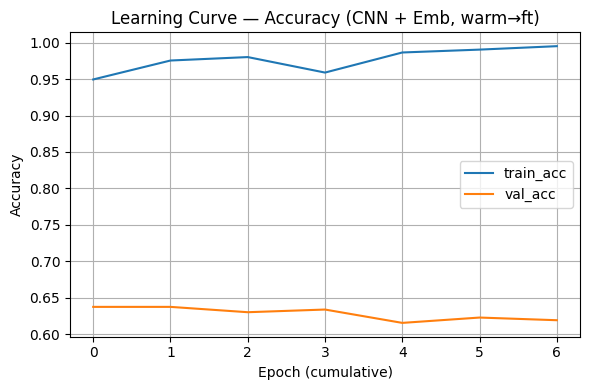

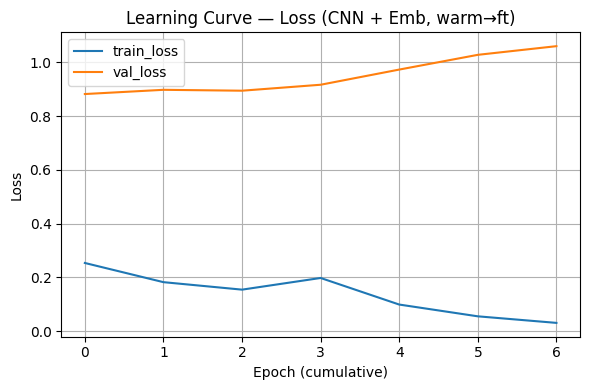

Best val_accuracy: 0.6374
Best val_loss    : 0.8822


In [113]:
# Gabungkan history warm-start & fine-tune agar plotnya rapi (akumulatif)
hist_acc     = (history_warm.history.get("accuracy", []) 
                + history_ft.history.get("accuracy", []))
hist_val_acc = (history_warm.history.get("val_accuracy", []) 
                + history_ft.history.get("val_accuracy", []))
hist_loss    = (history_warm.history.get("loss", []) 
                + history_ft.history.get("loss", []))
hist_val_loss= (history_warm.history.get("val_loss", []) 
                + history_ft.history.get("val_loss", []))

# Plot Accuracy
plt.figure(figsize=(6,4))
plt.plot(hist_acc,     label="train_acc")
plt.plot(hist_val_acc, label="val_acc")
plt.xlabel("Epoch (cumulative)"); plt.ylabel("Accuracy"); plt.title("Learning Curve — Accuracy (CNN + Emb, warm→ft)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Plot Loss
plt.figure(figsize=(6,4))
plt.plot(hist_loss,     label="train_loss")
plt.plot(hist_val_loss, label="val_loss")
plt.xlabel("Epoch (cumulative)"); plt.ylabel("Loss"); plt.title("Learning Curve — Loss (CNN + Emb, warm→ft)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

best_val_acc  = np.max(hist_val_acc)
best_val_loss = np.min(hist_val_loss)
print(f"Best val_accuracy: {best_val_acc:.4f}")
print(f"Best val_loss    : {best_val_loss:.4f}")

== Test Metrics ==
Accuracy: 0.5788
Macro-F1: 0.5788

Confusion Matrix (tabel):
         negatif  netral  positif
negatif       51      18       21
netral        14      56       21
positif       21      20       51


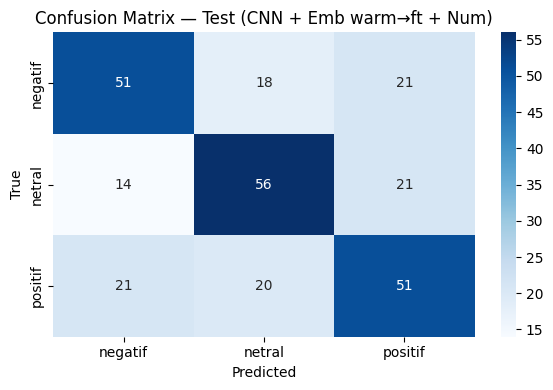


Classification Report:
              precision    recall  f1-score   support

     negatif       0.59      0.57      0.58        90
      netral       0.60      0.62      0.61        91
     positif       0.55      0.55      0.55        92

    accuracy                           0.58       273
   macro avg       0.58      0.58      0.58       273
weighted avg       0.58      0.58      0.58       273



In [114]:
Xte_in = [Xte_pad, Xte_num_std] if have_num else Xte_pad

y_prob_te = cnn_model.predict(Xte_in, verbose=0)
if n_classes == 2:
    y_hat_te = (y_prob_te.ravel() >= 0.5).astype("int32")
    y_true_te = y_te
else:
    y_hat_te = np.argmax(y_prob_te, axis=1)
    y_true_te = y_te

acc_te = accuracy_score(y_true_te, y_hat_te)
f1m_te = f1_score(y_true_te, y_hat_te, average="macro", zero_division=0)
print(f"== Test Metrics ==\nAccuracy: {acc_te:.4f}\nMacro-F1: {f1m_te:.4f}\n")

cm = confusion_matrix(y_true_te, y_hat_te, labels=np.arange(n_classes))
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
print("Confusion Matrix (tabel):")
print(cm_df)

plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — Test (CNN + Emb warm→ft + Num)")
plt.tight_layout(); plt.show()

print("\nClassification Report:")
print(classification_report(y_true_te, y_hat_te, target_names=list(le.classes_), zero_division=0))

# **3. Model Hybrid CNN+BiLSTM**

In [128]:
if 'embedding_matrix' not in globals():
    embedding_dim = dim  # dari kv.vector_size yang sudah diload
    embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype="float32")
    for w, idx in tok.word_index.items():
        if idx < vocab_size and w in kv:
            embedding_matrix[idx] = kv[w]
else:
    embedding_dim = embedding_matrix.shape[1]

print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (5114, 300)


In [130]:
n_classes = len(le.classes_)
if n_classes == 2:
    y_tr_oh, y_val_oh, y_te_oh = y_tr, y_val, y_te
    out_units, out_activation, loss_fn = 1, "sigmoid", "binary_crossentropy"
else:
    y_tr_oh  = to_categorical(y_tr,  num_classes=n_classes)
    y_val_oh = to_categorical(y_val, num_classes=n_classes)
    y_te_oh  = to_categorical(y_te,  num_classes=n_classes)
    out_units, out_activation, loss_fn = n_classes, "softmax", "categorical_crossentropy"

print("Configured ->", loss_fn, "| out_units:", out_units, "| act:", out_activation)

# class weight tipis berbasis 'class_weight' yang SUDAH ADA
class_weight_thin = {int(k): float(0.5 + 0.5*v) for k, v in class_weight.items()}

Configured -> categorical_crossentropy | out_units: 3 | act: softmax


In [131]:
have_num = Xtr_num_std is not None and Xtr_num_std.shape[1] > 0
seq_len  = Xtr_pad.shape[1]

# ---- Input teks (sequence) ----
seq_in = layers.Input(shape=(seq_len,), name="seq_in")

emb = layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=seq_len,
    mask_zero=True,          # agar padding (0) memperoleh mask
    trainable=True,
    name="embedding_trainable_hybrid"
)(seq_in)

x = layers.SpatialDropout1D(0.4, name="spdrop")(emb)
x = layers.Conv1D(64, kernel_size=3, activation='relu', padding="same", name="conv3")(x)
x = layers.Bidirectional(layers.LSTM(24, return_sequences=True, name="bilstm24"), name="bi")(x)

# ---- Attention bertopeng padding ----
# scores = Dense(1)(x) -> squeeze -> masking -> softmax -> context
scores = layers.Dense(1, name="att_dense")(x)                                   # (B, T, 1)
scores = layers.Lambda(lambda t: tf.squeeze(t, axis=-1), name="att_squeeze")(scores)  # (B, T)

# Mask dari pad (token 0)
mask = layers.Lambda(lambda s: tf.cast(tf.not_equal(s, 0), tf.float32), name="pad_mask")(seq_in)
minus_inf = layers.Lambda(lambda m: (1.0 - m) * -1e9, name="neg_mask")(mask)
scores = layers.Add(name="att_masked")([scores, minus_inf])

weights = layers.Activation('softmax', name="att_weights")(scores)              # (B, T)
weights_exp = layers.Lambda(lambda w: tf.expand_dims(w, axis=-1), name="att_expand")(weights)  # (B, T, 1)
h_text = layers.Lambda(lambda args: tf.reduce_sum(args[0]*args[1], axis=1),
                       name="att_context")([x, weights_exp])                    # (B, 2*hidden)

# ---- Cabang numerik ----
if have_num:
    num_in = layers.Input(shape=(Xtr_num_std.shape[1],), name="num_in")
    h_num  = layers.BatchNormalization(name="bn_num")(num_in)
    h_num  = layers.Dense(8, activation='relu', name="num_proj")(h_num)
    h      = layers.Concatenate(name="concat_text_num")([h_text, h_num])
    inputs = [seq_in, num_in]
else:
    h      = h_text
    inputs = seq_in

# ---- Head klasifikasi ----
h = layers.Dense(48, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4),
                 name="dense_48")(h)
h = layers.Dropout(0.5, name="drop_48")(h)
out = layers.Dense(out_units, activation=out_activation, name="output")(h)

hybrid_model = Model(inputs, out, name="Hybrid_CNN_BiLSTM_Att_NUM")
hybrid_model.summary()

Model: "Hybrid_CNN_BiLSTM_Att_NUM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 48)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_trainabl… │ (None, 48, 300)   │  1,534,200 │ seq_in[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spdrop              │ (None, 48, 300)   │          0 │ embedding_traina… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv1D)      │ (None, 48, 64)    │     57,664 │ spdrop[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi (Bidirectional)  │ (None, 48, 48)    │     17,088 │ conv3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_dense (Dense)   │ (None, 48, 1)     │         49 │ bi[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pad_mask (Lambda)   │ (None, 48)        │          0 │ seq_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_squeeze         │ (None, 48)        │          0 │ att_dense[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neg_mask (Lambda)   │ (None, 48)        │          0 │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_masked (Add)    │ (None, 48)        │          0 │ att_squeeze[0][0… │
│                     │                   │            │ neg_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_weights         │ (None, 48)        │          0 │ att_masked[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 5)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_expand (Lambda) │ (None, 48, 1)     │          0 │ att_weights[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_num              │ (None, 5)         │         20 │ num_in[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ att_context         │ (None, 48)        │          0 │ bi[0][0],         │
│ (Lambda)            │                   │            │ att_expand[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_proj (Dense)    │ (None, 8)         │         48 │ bn_num[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_text_num     │ (None, 56)        │          0 │ att_context[0][0… │
│ (Concatenate)       │                   │            │ num_proj[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 48)        │      2,736 │ concat_text_num[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_48 (Dropout)   │ (None, 48)        │          0 │ dense_48[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 3)         │        147 │ drop_48[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,611,952 (6.15 MB)

 Trainable params: 1,611,942 (6.15 MB)

 Non-trainable params: 10 (40.00 B)

In [132]:
opt = tf.keras.optimizers.Adam(learning_rate=8e-4, clipnorm=1.0)

hybrid_model.compile(
    optimizer=opt,
    loss=loss_fn,
    metrics=["accuracy"]
)

ckpt_path_hybrid = "best_hybrid_cnn_bilstm.h5"
cbs_hybrid = [
    ModelCheckpoint(ckpt_path_hybrid, monitor="val_accuracy", mode="max", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
]

# Siapkan input train/val
Xtr_in_h  = [Xtr_pad, Xtr_num_std]   if have_num else Xtr_pad
Xval_in_h = [Xval_pad, Xval_num_std] if have_num else Xval_pad

history_h = hybrid_model.fit(
    Xtr_in_h, y_tr_oh,
    validation_data=(Xval_in_h, y_val_oh),
    epochs=15, batch_size=16, verbose=1,
    callbacks=cbs_hybrid,
    class_weight=class_weight_thin
)

Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3873 - loss: 1.0946
Epoch 1: val_accuracy improved from None to 0.56044, saving model to best_hybrid_cnn_bilstm.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.4106 - loss: 1.0789 - val_accuracy: 0.5604 - val_loss: 0.9908 - learning_rate: 8.0000e-04
Epoch 2/15
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5563 - loss: 0.9688
Epoch 2: val_accuracy improved from 0.56044 to 0.63004, saving model to best_hybrid_cnn_bilstm.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.5831 - loss: 0.9313 - val_accuracy: 0.6300 - val_loss: 0.8529 - learning_rate: 8.0000e-04
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6912 - loss: 0.7560
Epoch 3: val_accuracy did not improve from 0.63004
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.7439 - loss: 0.6702 - val_accuracy: 0.6190 - val_loss: 0.9130 - learning_rate: 8.0000e-04
Epoch 4/15
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8117 - loss: 0.5106
Epoch 4: val_accuracy did not improve from 0.63004

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.8487 - loss: 0.4209 - val_accuracy: 0.6117 - val_loss: 1.1257 - learning_rate: 8.0000e-04
Epoch 5/15
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9164 - loss: 0.2955
Epoch 5: val_accuracy did not improve from 0.63004
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9362 - loss: 0.2285 - val_ac

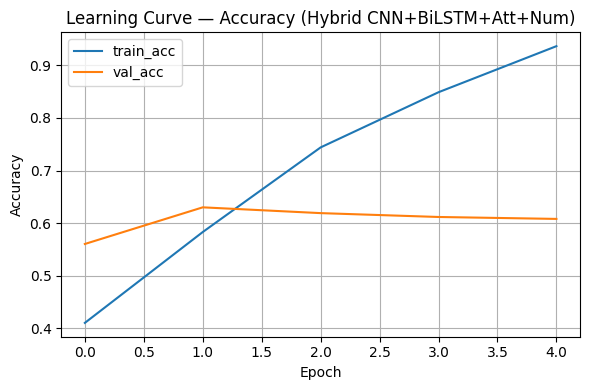

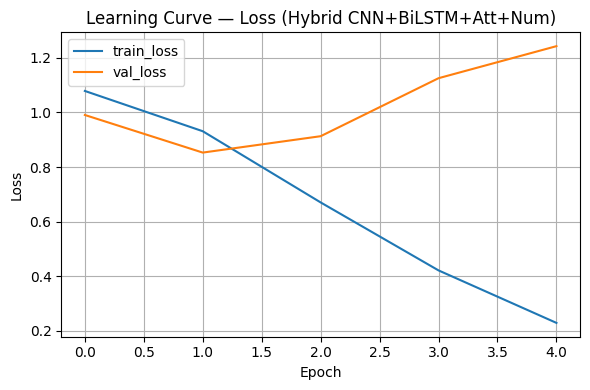

[Hybrid] Best val_accuracy: 0.6300
[Hybrid] Best val_loss    : 0.8529


In [133]:
# Accuracy
plt.figure(figsize=(6,4))
plt.plot(history_h.history["accuracy"],     label="train_acc")
plt.plot(history_h.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Learning Curve — Accuracy (Hybrid CNN+BiLSTM+Att+Num)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Loss
plt.figure(figsize=(6,4))
plt.plot(history_h.history["loss"],     label="train_loss")
plt.plot(history_h.history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Learning Curve — Loss (Hybrid CNN+BiLSTM+Att+Num)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

best_val_acc_h  = np.max(history_h.history["val_accuracy"])
best_val_loss_h = np.min(history_h.history["val_loss"])
print(f"[Hybrid] Best val_accuracy: {best_val_acc_h:.4f}")
print(f"[Hybrid] Best val_loss    : {best_val_loss_h:.4f}")

[Hybrid] == Test Metrics ==
Accuracy: 0.6264
Macro-F1: 0.6251

[Hybrid] Confusion Matrix (tabel):
         negatif  netral  positif
negatif       64      12       14
netral        16      56       19
positif       22      19       51


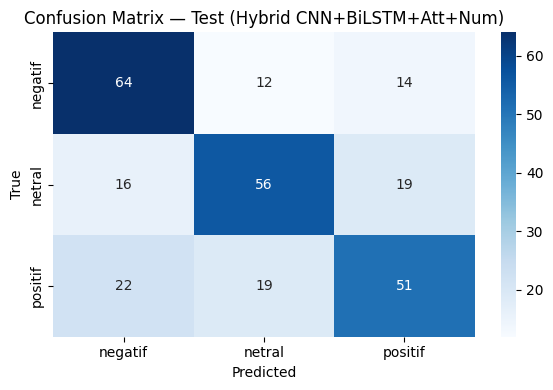


[Hybrid] Classification Report:
              precision    recall  f1-score   support

     negatif       0.63      0.71      0.67        90
      netral       0.64      0.62      0.63        91
     positif       0.61      0.55      0.58        92

    accuracy                           0.63       273
   macro avg       0.63      0.63      0.63       273
weighted avg       0.63      0.63      0.62       273



In [134]:
Xte_in_h = [Xte_pad, Xte_num_std] if have_num else Xte_pad

y_prob_te_h = hybrid_model.predict(Xte_in_h, verbose=0)
if n_classes == 2:
    y_hat_te_h = (y_prob_te_h.ravel() >= 0.5).astype("int32")
    y_true_te  = y_te
else:
    y_hat_te_h = np.argmax(y_prob_te_h, axis=1)
    y_true_te  = y_te

acc_te_h = accuracy_score(y_true_te, y_hat_te_h)
f1m_te_h = f1_score(y_true_te, y_hat_te_h, average="macro", zero_division=0)
print(f"[Hybrid] == Test Metrics ==\nAccuracy: {acc_te_h:.4f}\nMacro-F1: {f1m_te_h:.4f}\n")

cm_h = confusion_matrix(y_true_te, y_hat_te_h, labels=np.arange(n_classes))
cm_df_h = pd.DataFrame(cm_h, index=le.classes_, columns=le.classes_)
print("[Hybrid] Confusion Matrix (tabel):")
print(cm_df_h)

plt.figure(figsize=(6,4))
sns.heatmap(cm_df_h, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — Test (Hybrid CNN+BiLSTM+Att+Num)")
plt.tight_layout(); plt.show()

print("\n[Hybrid] Classification Report:")
print(classification_report(y_true_te, y_hat_te_h, target_names=list(le.classes_), zero_division=0))